In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from pandas.plotting import scatter_matrix
from keras.losses import mse
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.layers import Activation
from numpy.linalg import norm

%matplotlib inline

In [2]:
df_atmes = pd.read_csv("americanToadPadraoMes.csv")
#df_gfmes = pd.read_csv("greenFrogPadraoMes.csv")
#df_spmes = pd.read_csv("springPeeperPadraoMes.csv")
#df_atest = pd.read_csv("americanToadPadraoEstacao.csv")
#df_gfest = pd.read_csv("greenFrogPadraoEstacao.csv")
#df_spest = pd.read_csv("springPeeperPadraoEstacao.csv")

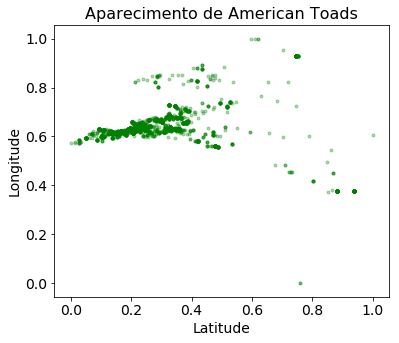

In [3]:
plt.figure(figsize=(6,5))
plt.rc('font',size=14)
plt.rc('axes',titlesize=16)
plt.scatter(df_atmes["lat"], df_atmes["lng"],marker=".",alpha='0.3',color="green")
plt.xlabel('Latitude')
plt.ylabel("Longitude")
plt.title("Aparecimento de American Toads")
plt.show()

# Autoencoder

In [4]:
df_atmes.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
input_dim = len(df_atmes.columns)
input_dim

28

In [6]:
# Rede com duas camadas decodificadas e batch_normalizzation e Tanh
encoding_dim1 = input_dim//2
entrada = Input(shape=(input_dim,))
batch1 = BatchNormalization()(entrada)
encoded1 = Dense(encoding_dim1,activation="tanh")(batch1)
dp2 = Dropout(0.1)(encoded1) 
encoded2 = Dense(encoding_dim1,activation="tanh")(dp2)
batch2 = BatchNormalization()(encoded2)
decoded = Dense(input_dim,activation="sigmoid")(batch2)

In [122]:
# Rede com duas camadas decodificadas e Tanh
encoding_dim1 = input_dim//2
entrada = Input(shape=(input_dim,))
encoded1 = Dense(encoding_dim1,activation="tanh")(entrada)
dp2 = Dropout(0.1)(encoded1) 
encoded2 = Dense(encoding_dim1,activation="tanh")(dp2)
decoded = Dense(input_dim,activation="sigmoid")(encoded2)

In [143]:
# Rede com duas camadas decodificadas e Relu e batch
encoding_dim1 = input_dim//2
entrada = Input(shape=(input_dim,))
batch1 = BatchNormalization()(entrada)
encoded1 = Dense(encoding_dim1,activation="relu")(batch1)
dp2 = Dropout(0.1)(encoded1) 
encoded2 = Dense(encoding_dim1,activation="relu")(dp2)
batch2 = BatchNormalization()(encoded2)
decoded = Dense(input_dim,activation="sigmoid")(batch2)

In [152]:
# Arquitetura que o professor falou
encoding_dim1 = input_dim//2
entrada = Input(shape=(input_dim,))
x = Dropout(0.3)(entrada)
x = Dense(encoding_dim1,activation="relu")(x)
decoded = Dense(input_dim,activation="sigmoid")(x)

In [198]:
# Outra tentativa
encoding_dim1 = input_dim//2
entrada = Input(shape=(input_dim,))
x = Dropout(0.3)(entrada)
x = Dense(input_dim,activation="tanh")(x)
decoded = Dense(input_dim,activation="sigmoid")(x)

In [199]:
# Cria o modelo para a rede anteriormente montada
autoencoder = Model(entrada,decoded)

In [200]:
# Compila o modelo com o método otimizador e a funlção de erro utilizadas
autoencoder.compile(optimizer='adam', loss='mse')

In [146]:
# Separa as base de treino e teste
X_trainAtMes, X_testAtMes = train_test_split(df_atmes, test_size=0.30, random_state=42)

In [137]:
batch = len(df_atmes)//10
batch

367

In [127]:
attest_dim = len(X_testAtMes)//10
attest_dim

110

In [201]:
# Treina a rede
# EarlyStopping para o treinamento se ver que não tá mais melhorando
# History é para plotar gráficos de erro
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, restore_best_weights=True)
history = autoencoder.fit(X_trainAtMes, X_trainAtMes,
                epochs=10000,
                batch_size=batch,
                shuffle=True,
                validation_split=0.3,
                callbacks=[es])

Train on 2572 samples, validate on 1103 samples
Epoch 1/10000
2572/2572 [==============================] - 9s 4ms/step - loss: 0.0903 - val_loss: 0.0801
Epoch 2/10000
2572/2572 [==============================] - 0s 8us/step - loss: 0.0790 - val_loss: 0.0689
Epoch 3/10000
2572/2572 [==============================] - 0s 14us/step - loss: 0.0692 - val_loss: 0.0599
Epoch 4/10000
2572/2572 [==============================] - 0s 19us/step - loss: 0.0614 - val_loss: 0.0525
Epoch 5/10000
2572/2572 [==============================] - 0s 18us/step - loss: 0.0544 - val_loss: 0.0464
Epoch 6/10000
2572/2572 [==============================] - 0s 14us/step - loss: 0.0486 - val_loss: 0.0412
Epoch 7/10000
2572/2572 [==============================] - 0s 20us/step - loss: 0.0437 - val_loss: 0.0369
Epoch 8/10000
2572/2572 [==============================] - 0s 15us/step - loss: 0.0395 - val_loss: 0.0334
Epoch 9/10000
2572/2572 [==============================] - 0s 18us/step - loss: 0.0359 - val_loss: 0.0305


2572/2572 [==============================] - 0s 16us/step - loss: 0.0147 - val_loss: 0.0121
Epoch 78/10000
2572/2572 [==============================] - 0s 14us/step - loss: 0.0148 - val_loss: 0.0119
Epoch 79/10000
2572/2572 [==============================] - 0s 19us/step - loss: 0.0146 - val_loss: 0.0118
Epoch 80/10000
2572/2572 [==============================] - 0s 18us/step - loss: 0.0145 - val_loss: 0.0118
Epoch 81/10000
2572/2572 [==============================] - 0s 20us/step - loss: 0.0145 - val_loss: 0.0117
Epoch 82/10000
2572/2572 [==============================] - 0s 15us/step - loss: 0.0144 - val_loss: 0.0117
Epoch 83/10000
2572/2572 [==============================] - 0s 17us/step - loss: 0.0144 - val_loss: 0.0116
Epoch 84/10000
2572/2572 [==============================] - 0s 18us/step - loss: 0.0144 - val_loss: 0.0116
Epoch 85/10000
2572/2572 [==============================] - 0s 18us/step - loss: 0.0143 - val_loss: 0.0116
Epoch 86/10000
2572/2572 [==========================

Epoch 153/10000
2572/2572 [==============================] - 0s 14us/step - loss: 0.0124 - val_loss: 0.0086
Epoch 154/10000
2572/2572 [==============================] - 0s 12us/step - loss: 0.0124 - val_loss: 0.0087
Epoch 155/10000
2572/2572 [==============================] - 0s 14us/step - loss: 0.0127 - val_loss: 0.0087
Epoch 156/10000
2572/2572 [==============================] - 0s 16us/step - loss: 0.0126 - val_loss: 0.0087
Epoch 157/10000
2572/2572 [==============================] - 0s 15us/step - loss: 0.0125 - val_loss: 0.0087
Epoch 158/10000
2572/2572 [==============================] - 0s 14us/step - loss: 0.0126 - val_loss: 0.0086
Epoch 159/10000
2572/2572 [==============================] - 0s 16us/step - loss: 0.0123 - val_loss: 0.0086
Epoch 160/10000
2572/2572 [==============================] - 0s 16us/step - loss: 0.0123 - val_loss: 0.0085
Epoch 161/10000
2572/2572 [==============================] - 0s 17us/step - loss: 0.0123 - val_loss: 0.0085
Epoch 162/10000
2572/2572 [=

Epoch 229/10000
2572/2572 [==============================] - 0s 14us/step - loss: 0.0119 - val_loss: 0.0076
Epoch 230/10000
2572/2572 [==============================] - 0s 13us/step - loss: 0.0119 - val_loss: 0.0075
Epoch 231/10000
2572/2572 [==============================] - 0s 17us/step - loss: 0.0118 - val_loss: 0.0076
Epoch 232/10000
2572/2572 [==============================] - 0s 19us/step - loss: 0.0121 - val_loss: 0.0076
Epoch 233/10000
2572/2572 [==============================] - 0s 19us/step - loss: 0.0121 - val_loss: 0.0076
Epoch 234/10000
2572/2572 [==============================] - 0s 14us/step - loss: 0.0122 - val_loss: 0.0076
Epoch 235/10000
2572/2572 [==============================] - 0s 20us/step - loss: 0.0120 - val_loss: 0.0076
Epoch 236/10000
2572/2572 [==============================] - 0s 14us/step - loss: 0.0120 - val_loss: 0.0075
Epoch 237/10000
2572/2572 [==============================] - 0s 18us/step - loss: 0.0120 - val_loss: 0.0076
Epoch 238/10000
2572/2572 [=

2572/2572 [==============================] - 0s 24us/step - loss: 0.0115 - val_loss: 0.0072
Epoch 305/10000
2572/2572 [==============================] - 0s 27us/step - loss: 0.0116 - val_loss: 0.0072
Epoch 306/10000
2572/2572 [==============================] - 0s 29us/step - loss: 0.0117 - val_loss: 0.0072
Epoch 307/10000
2572/2572 [==============================] - 0s 25us/step - loss: 0.0118 - val_loss: 0.0072
Epoch 308/10000
2572/2572 [==============================] - 0s 16us/step - loss: 0.0117 - val_loss: 0.0072
Epoch 309/10000
2572/2572 [==============================] - 0s 16us/step - loss: 0.0119 - val_loss: 0.0071
Epoch 310/10000
2572/2572 [==============================] - 0s 24us/step - loss: 0.0117 - val_loss: 0.0071
Epoch 311/10000
2572/2572 [==============================] - 0s 31us/step - loss: 0.0116 - val_loss: 0.0072
Epoch 312/10000
2572/2572 [==============================] - 0s 29us/step - loss: 0.0118 - val_loss: 0.0072
Epoch 313/10000
2572/2572 [=================

2572/2572 [==============================] - 0s 12us/step - loss: 0.0118 - val_loss: 0.0070
Epoch 381/10000
2572/2572 [==============================] - 0s 14us/step - loss: 0.0113 - val_loss: 0.0070
Epoch 382/10000
2572/2572 [==============================] - 0s 11us/step - loss: 0.0117 - val_loss: 0.0071
Epoch 383/10000
2572/2572 [==============================] - 0s 11us/step - loss: 0.0116 - val_loss: 0.0071
Epoch 384/10000
2572/2572 [==============================] - 0s 15us/step - loss: 0.0115 - val_loss: 0.0071
Epoch 385/10000
2572/2572 [==============================] - 0s 11us/step - loss: 0.0117 - val_loss: 0.0070
Epoch 386/10000
2572/2572 [==============================] - 0s 10us/step - loss: 0.0116 - val_loss: 0.0070
Epoch 387/10000
2572/2572 [==============================] - 0s 20us/step - loss: 0.0116 - val_loss: 0.0070
Epoch 388/10000
2572/2572 [==============================] - 0s 10us/step - loss: 0.0115 - val_loss: 0.0070
Epoch 389/10000
2572/2572 [=================

2572/2572 [==============================] - 0s 12us/step - loss: 0.0114 - val_loss: 0.0069
Epoch 457/10000
2572/2572 [==============================] - 0s 18us/step - loss: 0.0113 - val_loss: 0.0069
Epoch 458/10000
2572/2572 [==============================] - 0s 13us/step - loss: 0.0114 - val_loss: 0.0069
Epoch 459/10000
2572/2572 [==============================] - 0s 13us/step - loss: 0.0115 - val_loss: 0.0068
Epoch 460/10000
2572/2572 [==============================] - 0s 13us/step - loss: 0.0115 - val_loss: 0.0068
Epoch 461/10000
2572/2572 [==============================] - 0s 16us/step - loss: 0.0115 - val_loss: 0.0068
Epoch 462/10000
2572/2572 [==============================] - 0s 14us/step - loss: 0.0114 - val_loss: 0.0068
Epoch 463/10000
2572/2572 [==============================] - 0s 16us/step - loss: 0.0113 - val_loss: 0.0068
Epoch 464/10000
2572/2572 [==============================] - 0s 12us/step - loss: 0.0113 - val_loss: 0.0067
Epoch 465/10000
2572/2572 [=================

2572/2572 [==============================] - 0s 10us/step - loss: 0.0113 - val_loss: 0.0067
Epoch 533/10000
2572/2572 [==============================] - 0s 12us/step - loss: 0.0110 - val_loss: 0.0067
Epoch 534/10000
2572/2572 [==============================] - 0s 14us/step - loss: 0.0111 - val_loss: 0.0067
Epoch 535/10000
2572/2572 [==============================] - 0s 12us/step - loss: 0.0112 - val_loss: 0.0067
Epoch 536/10000
2572/2572 [==============================] - 0s 11us/step - loss: 0.0112 - val_loss: 0.0068
Epoch 537/10000
2572/2572 [==============================] - 0s 16us/step - loss: 0.0112 - val_loss: 0.0067
Epoch 538/10000
2572/2572 [==============================] - 0s 11us/step - loss: 0.0112 - val_loss: 0.0067
Epoch 539/10000
2572/2572 [==============================] - 0s 11us/step - loss: 0.0113 - val_loss: 0.0067
Epoch 540/10000
2572/2572 [==============================] - 0s 10us/step - loss: 0.0112 - val_loss: 0.0067
Epoch 541/10000
2572/2572 [=================

2572/2572 [==============================] - 0s 12us/step - loss: 0.0112 - val_loss: 0.0068
Epoch 609/10000
2572/2572 [==============================] - 0s 11us/step - loss: 0.0111 - val_loss: 0.0069
Epoch 610/10000
2572/2572 [==============================] - 0s 11us/step - loss: 0.0113 - val_loss: 0.0069
Restoring model weights from the end of the best epoch
Epoch 00610: early stopping


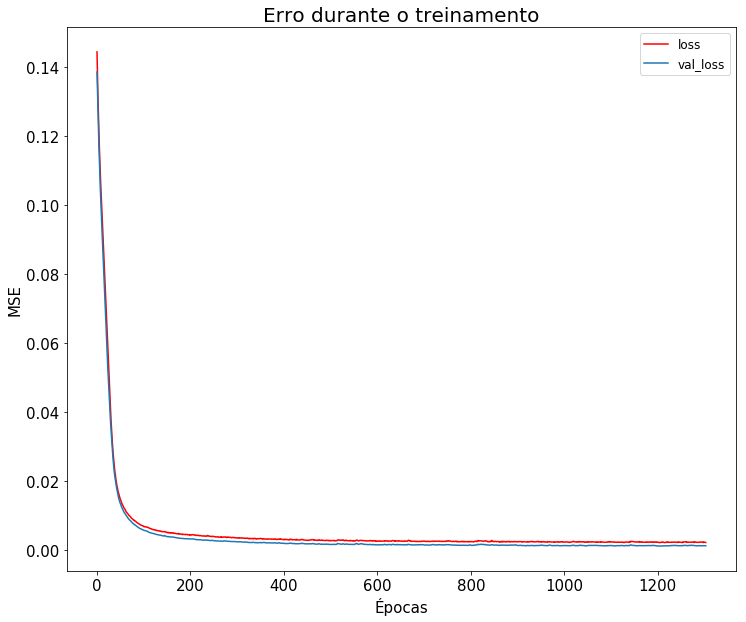

In [13]:
# Plota gráfico de comparação entre erro e erro de validação
plt.figure(figsize=(12,10))
plt.rc('axes', titlesize=20)
plt.rc('font', size=15)
plt.plot(history.history['loss'],color='r',label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.xlabel(u"Épocas")
plt.ylabel("MSE")
plt.title("Erro durante o treinamento")
plt.rc('font', size=12)
plt.legend()
plt.show()

In [14]:
# Faz a previsão para a base de teste
testeAtMes = autoencoder.predict(X_testAtMes)

In [15]:
# Calcula o erro (MSE) para o teste
autoencoder.evaluate(x=X_testAtMes, y=X_testAtMes, batch_size=attest_dim)
#20% de dropout: 0.0016651906830162412
#30% de dropout: 0.12273836268258981

1103/1103 [==============================] - 0s 15us/step


0.0010867598001124948

In [16]:
# Calcula o erro (MSE) para o treino
autoencoder.evaluate(x=X_trainAtMes, y=X_trainAtMes, batch_size=batch)
#20% de dropout: 0.0016855491797981457
#30% de dropout: 0.12279615244751399

2572/2572 [==============================] - 0s 6us/step


0.0010984422877138701

## Sem batch e com tanh

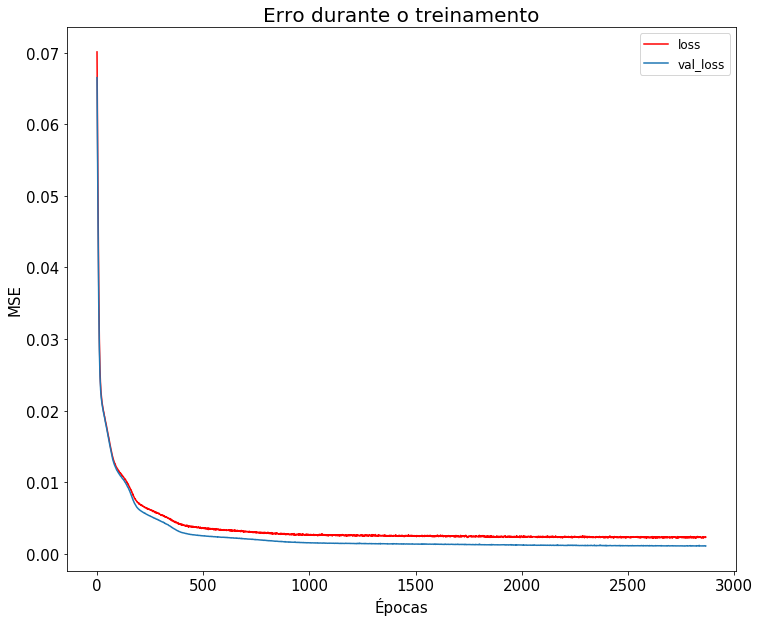

In [129]:
# Plota gráfico de comparação entre erro e erro de validação
plt.figure(figsize=(12,10))
plt.rc('axes', titlesize=20)
plt.rc('font', size=15)
plt.plot(history.history['loss'],color='r',label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.xlabel(u"Épocas")
plt.ylabel("MSE")
plt.title("Erro durante o treinamento")
plt.rc('font', size=12)
plt.legend()
plt.show()

In [130]:
# Faz a previsão para a base de teste
testeAtMes = autoencoder.predict(X_testAtMes)

In [131]:
# Calcula o erro (MSE) para o teste
autoencoder.evaluate(x=X_testAtMes, y=X_testAtMes, batch_size=attest_dim)
#20% de dropout: 0.0016651906830162412
#30% de dropout: 0.12273836268258981

1103/1103 [==============================] - 0s 13us/step


0.0010582215491161324

In [132]:
# Calcula o erro (MSE) para o treino
autoencoder.evaluate(x=X_trainAtMes, y=X_trainAtMes, batch_size=batch)
#20% de dropout: 0.0016855491797981457
#30% de dropout: 0.12279615244751399

2572/2572 [==============================] - 0s 4us/step


0.0010643169536839368

## Com batch e relu

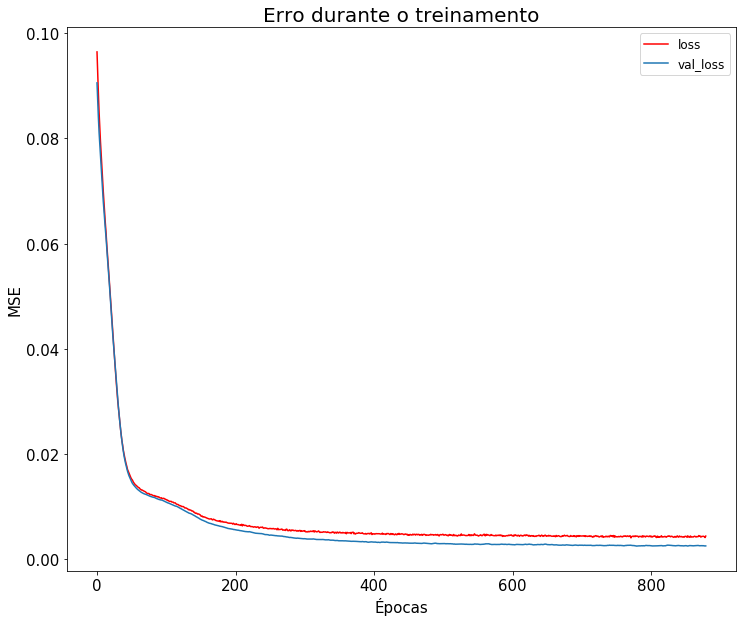

In [148]:
# Plota gráfico de comparação entre erro e erro de validação
plt.figure(figsize=(12,10))
plt.rc('axes', titlesize=20)
plt.rc('font', size=15)
plt.plot(history.history['loss'],color='r',label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.xlabel(u"Épocas")
plt.ylabel("MSE")
plt.title("Erro durante o treinamento")
plt.rc('font', size=12)
plt.legend()
plt.show()

In [149]:
# Faz a previsão para a base de teste
testeAtMes = autoencoder.predict(X_testAtMes)

In [150]:
# Calcula o erro (MSE) para o teste
autoencoder.evaluate(x=X_testAtMes, y=X_testAtMes, batch_size=attest_dim)
#20% de dropout: 0.0016651906830162412
#30% de dropout: 0.12273836268258981

1103/1103 [==============================] - 0s 16us/step


0.002409292094524298

In [151]:
# Calcula o erro (MSE) para o treino
autoencoder.evaluate(x=X_trainAtMes, y=X_trainAtMes, batch_size=batch)
#20% de dropout: 0.0016855491797981457
#30% de dropout: 0.12279615244751399

2572/2572 [==============================] - 0s 7us/step


0.002384762919068331

## Arquitetura do Juan

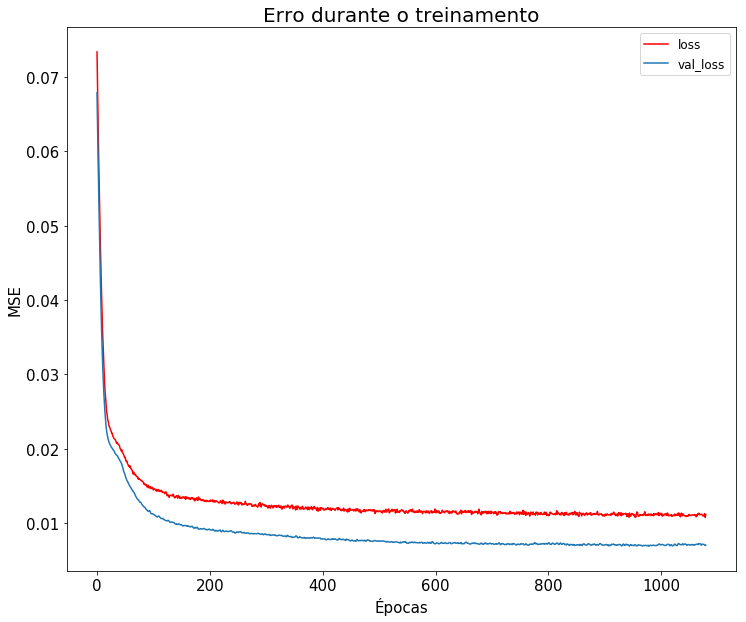

In [156]:
# Plota gráfico de comparação entre erro e erro de validação
plt.figure(figsize=(12,10))
plt.rc('axes', titlesize=20)
plt.rc('font', size=15)
plt.plot(history.history['loss'],color='r',label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.xlabel(u"Épocas")
plt.ylabel("MSE")
plt.title("Erro durante o treinamento")
plt.rc('font', size=12)
plt.legend()
plt.show()

In [157]:
# Faz a previsão para a base de teste
testeAtMes = autoencoder.predict(X_testAtMes)

In [158]:
# Calcula o erro (MSE) para o teste
autoencoder.evaluate(x=X_testAtMes, y=X_testAtMes, batch_size=attest_dim)
#20% de dropout: 0.0016651906830162412
#30% de dropout: 0.12273836268258981

1103/1103 [==============================] - 0s 20us/step


0.006945387239492788

In [159]:
# Calcula o erro (MSE) para o treino
autoencoder.evaluate(x=X_trainAtMes, y=X_trainAtMes, batch_size=batch)
#20% de dropout: 0.0016855491797981457
#30% de dropout: 0.12279615244751399

2572/2572 [==============================] - 0s 7us/step


0.006900410083050855

## Arquitetura do Juan com modificação

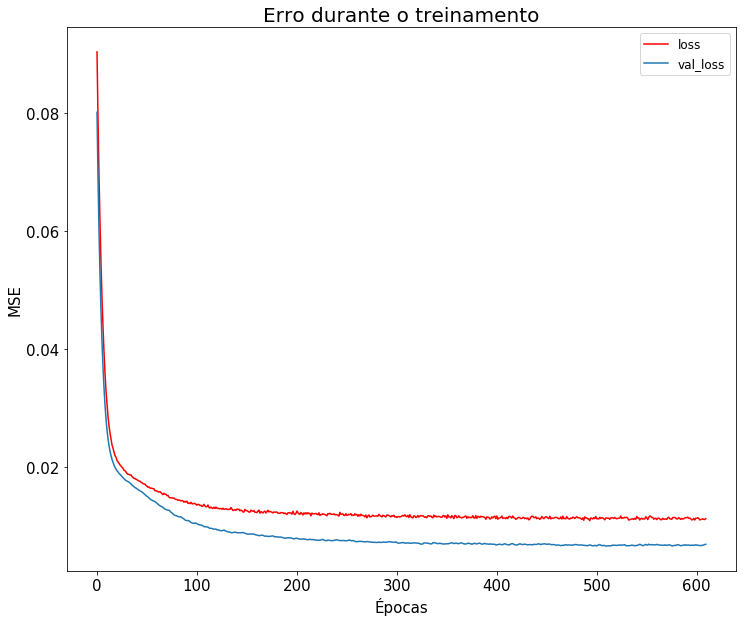

In [202]:
# Plota gráfico de comparação entre erro e erro de validação
plt.figure(figsize=(12,10))
plt.rc('axes', titlesize=20)
plt.rc('font', size=15)
plt.plot(history.history['loss'],color='r',label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.xlabel(u"Épocas")
plt.ylabel("MSE")
plt.title("Erro durante o treinamento")
plt.rc('font', size=12)
plt.legend()
plt.show()

In [203]:
# Faz a previsão para a base de teste
testeAtMes = autoencoder.predict(X_testAtMes)

In [204]:
# Calcula o erro (MSE) para o teste
autoencoder.evaluate(x=X_testAtMes, y=X_testAtMes, batch_size=attest_dim)
#20% de dropout: 0.0016651906830162412
#30% de dropout: 0.12273836268258981

1103/1103 [==============================] - 0s 35us/step


0.006627441617362168

In [205]:
# Calcula o erro (MSE) para o treino
autoencoder.evaluate(x=X_trainAtMes, y=X_trainAtMes, batch_size=batch)
#20% de dropout: 0.0016855491797981457
#30% de dropout: 0.12279615244751399

2572/2572 [==============================] - 0s 7us/step


0.006526532894978807

# Feature Selection

## Métricas de Características da Base

In [17]:
def classifica_dict(d, reverso):
    feature = []
    valor = []
    for b in sorted(d, key = d.get,reverse=reverso):
        feature.append(b)
        valor.append(d[b])
    return feature, valor

In [24]:
def interquartile_ranking_ranking(data):
    ir = {}
    zeros = {}
    for c in data.columns:
        inter = data[c].quantile(q=0.75) - data[c].quantile(q=0.25)
        if (inter == 0):
            zeros[c] = inter
        else:
            ir[c] = inter 
    return classifica_dict(ir,reverso=False), zeros

In [27]:
ir, zeros = interquartile_ranking_ranking(df_atmes)
ir

(['lng',
  'maxwspdm',
  'meanwindspdm',
  'date',
  'maxtempm',
  'meantempm',
  'minwspdm',
  'mintempm',
  'lat',
  'maxdewptm',
  'heatingdegreedays',
  'maxpressurem',
  'mindewptm',
  'meanpressurem',
  'maxhumidity',
  'minpressurem',
  'meandewptm',
  'humidity',
  'minhumidity',
  'gdegreedays',
  'meanwdird'],
 [0.031597279692543,
  0.05500000000000001,
  0.05714285714285715,
  0.09090909090909088,
  0.11764705882352944,
  0.12962962962962965,
  0.1313131313131313,
  0.13793103448275867,
  0.15135276256531535,
  0.1568627450980392,
  0.15789473684210528,
  0.16326530612244888,
  0.16666666666666674,
  0.17071147064924203,
  0.1842105263157895,
  0.19148936170212771,
  0.1923076923076923,
  0.25,
  0.27083333333333326,
  0.4,
  0.6481994459833795])

In [28]:
for c in zeros.keys():
    df_atmes.drop(c,axis=1,inplace=True)
zeros

{'coolingdegreedays': 0.0,
 'fog': 0.0,
 'hail': 0.0,
 'precipm': 0.0,
 'rain': 0.0,
 'snow': 0.0,
 'thunder': 0.0}

## Agregação de Rankings

## Análise de Reconstrução

In [29]:
def mean_squared_error(y_true, y_pred):
    return np.mean(np.square(y_pred - y_true))

In [30]:
# Calcula o erro (MSE) para o treino
scores = mean_squared_error(X_testAtMes, testeAtMes)
# Transforma em dict
score = {}
for c in scores.keys():
    score[c] = scores[c]
score

{'coolingdegreedays': 0.0014338002309615015,
 'date': 0.0013190348220738276,
 'fog': 3.678816968213743e-05,
 'gdegreedays': 0.002362563273895962,
 'hail': 2.990422628186032e-05,
 'heatingdegreedays': 0.000789970318222739,
 'humidity': 0.0021853405616149807,
 'lat': 0.0012640446207883606,
 'lng': 0.0015849969891147903,
 'maxdewptm': 0.0011140634993085249,
 'maxhumidity': 0.0020115554453334576,
 'maxpressurem': 0.0013923948368688558,
 'maxtempm': 0.000936767815774992,
 'maxwspdm': 0.0009453334748468783,
 'meandewptm': 0.0005098494215945843,
 'meanpressurem': 0.0008258411747728979,
 'meantempm': 0.0003535976290049033,
 'meanwdird': 0.0025301085454172857,
 'meanwindspdm': 0.0006126538496080806,
 'mindewptm': 0.0011441367033406368,
 'minhumidity': 0.0015816554666523795,
 'minpressurem': 0.0016094179688043776,
 'mintempm': 0.0008877488302324221,
 'minwspdm': 0.00229515831551315,
 'precipm': 0.0005370160836007373,
 'rain': 6.315110307017285e-05,
 'snow': 2.6760215338208214e-05,
 'thunder': 4.

ValueError: zero-size array to reduction operation maximum which has no identity

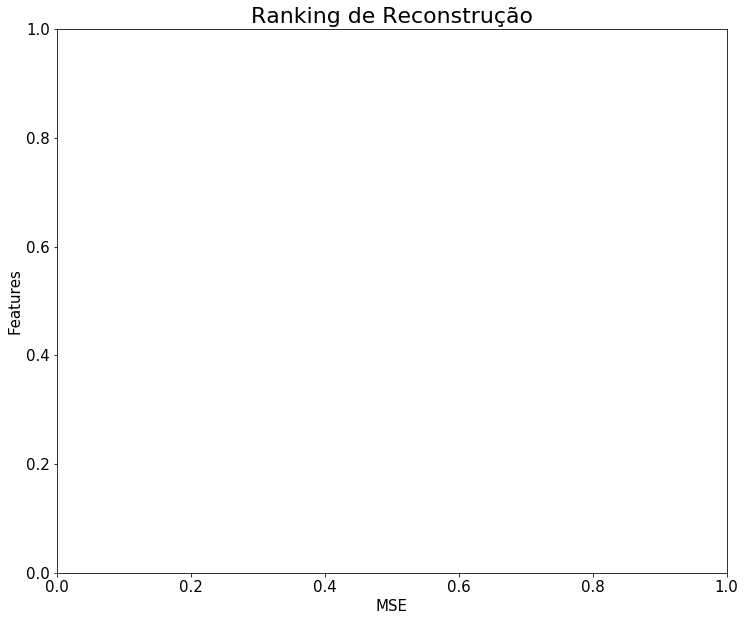

In [31]:
bads = []
values = []
rank = []
rankv = []
# Ranqueia
for b in sorted(score, key = score.get,reverse=True):
    rank.append(b)
    rankv.append(score[b])
    
# Separa as ruins
for a in sorted(score, key = score.get,reverse=True):
    if(score[a] > 0.003):
        print(a,score[a])
        bads.append(a)
        values.append(score[a])
        rank.remove(a)
        rankv.remove(score[a])

# Plota gráfico de barras horizontais
plt.figure(figsize=(12,10))
plt.rc('font', size=15)
plt.rc('axes', titlesize=22)
plt.title(u"Ranking de Reconstrução")
plt.xlabel("MSE")
plt.ylabel("Features")
plt.plot([0,np.max(values)],[len(bads),len(bads)],c='r',linewidth=3)
bads.append('')
values.append(0)
plt.barh(bads,values,color='grey',label='Eliminadas')
plt.barh(rank,rankv,color='green',label='Mantidas')
plt.legend()
plt.show()

In [ ]:
df_atmes.info()

In [ ]:
# Plota matriz de correlação
# Quanto mais correlacionadas duas features, mais forte é a cor de interseção entre elas
# crescem justas na mesma direção = bem correlacionadas
# crescem em direções opostas = mal correlacionadas
plt.rc('font', size=15)
plt.rc('axes', titlesize=22)
correlations = df_atmes.corr()
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,input_dim,1)
ax.set_yticks(ticks)
ax.set_xticks(ticks)
ax.set_xticklabels(df_atmes.columns,rotation=90)
ax.set_yticklabels(df_atmes.columns)
plt.show()

## Treinamento de Rede Final com as features selecionadas

In [59]:
input_dim = len(df_atmes.columns)
input_dim

21

In [334]:
# Rede com duas camadas decodificadas e batch_normalizzation e Tanh
encoding_dim1 = input_dim//2
entrada = Input(shape=(input_dim,))
batch1 = BatchNormalization()(entrada)
encoded1 = Dense(encoding_dim1,activation="tanh")(batch1)
dp2 = Dropout(0.1)(encoded1)
encoded2 = Dense(encoding_dim1,activation="tanh")(dp2)
batch2 = BatchNormalization()(encoded2)
decoded = Dense(input_dim,activation="sigmoid")(batch2)

In [335]:
# Cria o modelo para a rede anteriormente montada
final_autoencoder = Model(entrada,decoded)

In [336]:
# Compila o modelo com o método otimizador e a funlção de erro utilizadas
final_autoencoder.compile(optimizer='adam', loss='mse')

In [83]:
# Separa as base de treino e teste
X_trainAtMes, X_testAtMes = train_test_split(df_atmes, test_size=0.30, random_state=42)

In [84]:
batch = len(df_atmes)//10
batch
attest_dim = len(X_testAtMes)//10
attest_dim

110

In [337]:
# Treina a rede
# EarlyStopping para o treinamento se ver que não tá mais melhorando
# History é para plotar gráficos de erro
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, restore_best_weights=True)
history = final_autoencoder.fit(X_trainAtMes, X_trainAtMes,
                epochs=3000,
                batch_size=batch,
                shuffle=True,
                validation_split=0.3,
                callbacks=[es])

Train on 1800 samples, validate on 772 samples
Epoch 1/3000
1800/1800 [==============================] - 13s 7ms/step - loss: 0.1089 - val_loss: 0.1031
Epoch 2/3000
1800/1800 [==============================] - 0s 19us/step - loss: 0.1045 - val_loss: 0.0986
Epoch 3/3000
1800/1800 [==============================] - 0s 19us/step - loss: 0.1007 - val_loss: 0.0944
Epoch 4/3000
1800/1800 [==============================] - 0s 25us/step - loss: 0.0962 - val_loss: 0.0905
Epoch 5/3000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0924 - val_loss: 0.0870
Epoch 6/3000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0887 - val_loss: 0.0837
Epoch 7/3000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0857 - val_loss: 0.0807
Epoch 8/3000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0825 - val_loss: 0.0778
Epoch 9/3000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0799 - val_loss: 0.0752
Epoch 10

Epoch 78/3000
1800/1800 [==============================] - 0s 25us/step - loss: 0.0087 - val_loss: 0.0073
Epoch 79/3000
1800/1800 [==============================] - 0s 27us/step - loss: 0.0085 - val_loss: 0.0072
Epoch 80/3000
1800/1800 [==============================] - 0s 26us/step - loss: 0.0083 - val_loss: 0.0070
Epoch 81/3000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0082 - val_loss: 0.0069
Epoch 82/3000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0081 - val_loss: 0.0068
Epoch 83/3000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0078 - val_loss: 0.0066
Epoch 84/3000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0078 - val_loss: 0.0065
Epoch 85/3000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 86/3000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0075 - val_loss: 0.0063
Epoch 87/3000
1800/1800 [=====================

Epoch 155/3000
1800/1800 [==============================] - 0s 32us/step - loss: 0.0041 - val_loss: 0.0032
Epoch 156/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0041 - val_loss: 0.0032
Epoch 157/3000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0042 - val_loss: 0.0031
Epoch 158/3000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0041 - val_loss: 0.0031
Epoch 159/3000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0041 - val_loss: 0.0031
Epoch 160/3000
1800/1800 [==============================] - 0s 28us/step - loss: 0.0042 - val_loss: 0.0031
Epoch 161/3000
1800/1800 [==============================] - 0s 28us/step - loss: 0.0041 - val_loss: 0.0031
Epoch 162/3000
1800/1800 [==============================] - 0s 25us/step - loss: 0.0040 - val_loss: 0.0031
Epoch 163/3000
1800/1800 [==============================] - 0s 25us/step - loss: 0.0041 - val_loss: 0.0030
Epoch 164/3000
1800/1800 [===========

1800/1800 [==============================] - 0s 18us/step - loss: 0.0034 - val_loss: 0.0023
Epoch 232/3000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0034 - val_loss: 0.0023
Epoch 233/3000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0033 - val_loss: 0.0023
Epoch 234/3000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0032 - val_loss: 0.0023
Epoch 235/3000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0033 - val_loss: 0.0023
Epoch 236/3000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0033 - val_loss: 0.0023
Epoch 237/3000
1800/1800 [==============================] - 0s 25us/step - loss: 0.0032 - val_loss: 0.0023
Epoch 238/3000
1800/1800 [==============================] - 0s 32us/step - loss: 0.0033 - val_loss: 0.0023
Epoch 239/3000
1800/1800 [==============================] - 0s 27us/step - loss: 0.0033 - val_loss: 0.0023
Epoch 240/3000
1800/1800 [==========================

1800/1800 [==============================] - 0s 17us/step - loss: 0.0029 - val_loss: 0.0019
Epoch 308/3000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0029 - val_loss: 0.0019
Epoch 309/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0029 - val_loss: 0.0019
Epoch 310/3000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0031 - val_loss: 0.0019
Epoch 311/3000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0030 - val_loss: 0.0019
Epoch 312/3000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0031 - val_loss: 0.0019
Epoch 313/3000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0031 - val_loss: 0.0019
Epoch 314/3000
1800/1800 [==============================] - 0s 25us/step - loss: 0.0031 - val_loss: 0.0019
Epoch 315/3000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0031 - val_loss: 0.0019
Epoch 316/3000
1800/1800 [==========================

1800/1800 [==============================] - 0s 18us/step - loss: 0.0028 - val_loss: 0.0017
Epoch 384/3000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0029 - val_loss: 0.0017
Epoch 385/3000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0028 - val_loss: 0.0017
Epoch 386/3000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0029 - val_loss: 0.0017
Epoch 387/3000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0028 - val_loss: 0.0017
Epoch 388/3000
1800/1800 [==============================] - 0s 25us/step - loss: 0.0028 - val_loss: 0.0017
Epoch 389/3000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0028 - val_loss: 0.0017
Epoch 390/3000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0029 - val_loss: 0.0017
Epoch 391/3000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0029 - val_loss: 0.0017
Epoch 392/3000
1800/1800 [==========================

1800/1800 [==============================] - 0s 21us/step - loss: 0.0026 - val_loss: 0.0016
Epoch 460/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0028 - val_loss: 0.0016
Epoch 461/3000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0029 - val_loss: 0.0016
Epoch 462/3000
1800/1800 [==============================] - 0s 26us/step - loss: 0.0027 - val_loss: 0.0016
Epoch 463/3000
1800/1800 [==============================] - 0s 28us/step - loss: 0.0028 - val_loss: 0.0016
Epoch 464/3000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0027 - val_loss: 0.0016
Epoch 465/3000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0028 - val_loss: 0.0016
Epoch 466/3000
1800/1800 [==============================] - 0s 28us/step - loss: 0.0027 - val_loss: 0.0016
Epoch 467/3000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0028 - val_loss: 0.0016
Epoch 468/3000
1800/1800 [==========================

1800/1800 [==============================] - 0s 23us/step - loss: 0.0025 - val_loss: 0.0014
Epoch 536/3000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0026 - val_loss: 0.0014
Epoch 537/3000
1800/1800 [==============================] - 0s 25us/step - loss: 0.0025 - val_loss: 0.0014
Epoch 538/3000
1800/1800 [==============================] - 0s 27us/step - loss: 0.0026 - val_loss: 0.0014
Epoch 539/3000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0025 - val_loss: 0.0014
Epoch 540/3000
1800/1800 [==============================] - 0s 35us/step - loss: 0.0026 - val_loss: 0.0014
Epoch 541/3000
1800/1800 [==============================] - 0s 28us/step - loss: 0.0027 - val_loss: 0.0014
Epoch 542/3000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0027 - val_loss: 0.0014
Epoch 543/3000
1800/1800 [==============================] - 0s 28us/step - loss: 0.0026 - val_loss: 0.0014
Epoch 544/3000
1800/1800 [==========================

1800/1800 [==============================] - 0s 20us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 612/3000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0026 - val_loss: 0.0013
Epoch 613/3000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 614/3000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0026 - val_loss: 0.0013
Epoch 615/3000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 616/3000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 617/3000
1800/1800 [==============================] - 0s 21us/step - loss: 0.0026 - val_loss: 0.0013
Epoch 618/3000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0026 - val_loss: 0.0013
Epoch 619/3000
1800/1800 [==============================] - 0s 25us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 620/3000
1800/1800 [==========================

1800/1800 [==============================] - 0s 21us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 688/3000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0024 - val_loss: 0.0013
Epoch 689/3000
1800/1800 [==============================] - 0s 35us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 690/3000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0024 - val_loss: 0.0013
Epoch 691/3000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 692/3000
1800/1800 [==============================] - 0s 22us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 693/3000
1800/1800 [==============================] - 0s 35us/step - loss: 0.0026 - val_loss: 0.0012
Epoch 694/3000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 695/3000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0026 - val_loss: 0.0012
Epoch 696/3000
1800/1800 [==========================

1800/1800 [==============================] - 0s 16us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 764/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 765/3000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 766/3000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 767/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 768/3000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 769/3000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 770/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 771/3000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 772/3000
1800/1800 [==========================

1800/1800 [==============================] - 0s 16us/step - loss: 0.0024 - val_loss: 0.0013
Epoch 840/3000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0023 - val_loss: 0.0013
Epoch 841/3000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0023 - val_loss: 0.0012
Epoch 842/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 843/3000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 844/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0023 - val_loss: 0.0013
Epoch 845/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 846/3000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 847/3000
1800/1800 [==============================] - 0s 32us/step - loss: 0.0023 - val_loss: 0.0012
Epoch 848/3000
1800/1800 [==========================

1800/1800 [==============================] - 0s 14us/step - loss: 0.0023 - val_loss: 0.0012
Epoch 916/3000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 917/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 918/3000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0023 - val_loss: 0.0012
Epoch 919/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 920/3000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 921/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 922/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 923/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0023 - val_loss: 0.0012
Epoch 924/3000
1800/1800 [==========================

1800/1800 [==============================] - 0s 29us/step - loss: 0.0023 - val_loss: 0.0012
Epoch 992/3000
1800/1800 [==============================] - 0s 26us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 993/3000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 994/3000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0023 - val_loss: 0.0012
Epoch 995/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 996/3000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0023 - val_loss: 0.0012
Epoch 997/3000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 998/3000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 999/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0023 - val_loss: 0.0012
Epoch 1000/3000
1800/1800 [=========================

Epoch 1067/3000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 1068/3000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 1069/3000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1070/3000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 1071/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0022 - val_loss: 0.0011
Epoch 1072/3000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 1073/3000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 1074/3000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 1075/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 1076/3000
1800/1800 [=

Epoch 1143/3000
1800/1800 [==============================] - 0s 20us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1144/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1145/3000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1146/3000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1147/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1148/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0022 - val_loss: 0.0011
Epoch 1149/3000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1150/3000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1151/3000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1152/3000
1800/1800 [=

Epoch 1219/3000
1800/1800 [==============================] - 0s 23us/step - loss: 0.0022 - val_loss: 0.0011
Epoch 1220/3000
1800/1800 [==============================] - 0s 36us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 1221/3000
1800/1800 [==============================] - 0s 34us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 1222/3000
1800/1800 [==============================] - 0s 29us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1223/3000
1800/1800 [==============================] - 0s 28us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 1224/3000
1800/1800 [==============================] - 0s 28us/step - loss: 0.0021 - val_loss: 0.0011
Epoch 1225/3000
1800/1800 [==============================] - 0s 12us/step - loss: 0.0022 - val_loss: 0.0011
Epoch 1226/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0022 - val_loss: 0.0011
Epoch 1227/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1228/3000
1800/1800 [=

Epoch 1295/3000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 1296/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1297/3000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1298/3000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1299/3000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0022 - val_loss: 9.9940e-04
Epoch 1300/3000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0023 - val_loss: 9.9605e-04
Epoch 1301/3000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1302/3000
1800/1800 [==============================] - 0s 17us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 1303/3000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1304/3000
1800

1800/1800 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1371/3000
1800/1800 [==============================] - 0s 36us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1372/3000
1800/1800 [==============================] - 0s 19us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1373/3000
1800/1800 [==============================] - 0s 24us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1374/3000
1800/1800 [==============================] - 0s 40us/step - loss: 0.0022 - val_loss: 9.9242e-04
Epoch 1375/3000
1800/1800 [==============================] - 0s 34us/step - loss: 0.0023 - val_loss: 9.6334e-04
Epoch 1376/3000
1800/1800 [==============================] - 0s 28us/step - loss: 0.0023 - val_loss: 9.6141e-04
Epoch 1377/3000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0022 - val_loss: 9.7344e-04
Epoch 1378/3000
1800/1800 [==============================] - 0s 18us/step - loss: 0.0022 - val_loss: 9.8027e-04
Epoch 1379/3000
1800/180

1800/1800 [==============================] - 0s 15us/step - loss: 0.0022 - val_loss: 9.8694e-04
Epoch 1446/3000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1447/3000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 1448/3000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 1449/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1450/3000
1800/1800 [==============================] - 0s 13us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1451/3000
1800/1800 [==============================] - 0s 15us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1452/3000
1800/1800 [==============================] - 0s 16us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1453/3000
1800/1800 [==============================] - 0s 14us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 1454/3000
1800/1800 [=============

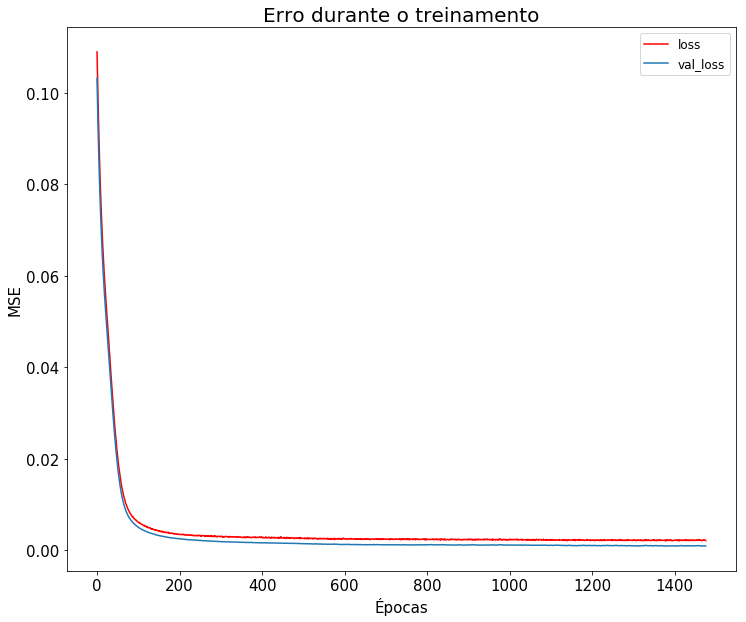

In [338]:
# Plota gráfico de comparação entre erro e erro de validação
plt.figure(figsize=(12,10))
plt.rc('axes', titlesize=20)
plt.rc('font', size=15)
plt.plot(history.history['loss'],color='r',label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.xlabel(u"Épocas")
plt.ylabel("MSE")
plt.title("Erro durante o treinamento")
plt.rc('font', size=12)
plt.legend()
plt.show()

In [339]:
# Faz a previsão para a base de teste
testeAtMes = final_autoencoder.predict(X_testAtMes)

In [340]:
# Calcula o erro (MSE) para o teste
final_autoencoder.evaluate(x=X_testAtMes, y=X_testAtMes, batch_size=attest_dim)

1103/1103 [==============================] - 0s 20us/step


0.0009857907452526

In [341]:
# Calcula o erro (MSE) para o treino
final_autoencoder.evaluate(x=X_trainAtMes, y=X_trainAtMes, batch_size=batch)

2572/2572 [==============================] - 0s 10us/step


0.0009754174019602558

# Estimação de Probabilidade

In [225]:
# Pn = e^-(||x-x^||)
def estimar_prob1(entrada):
    recons = final_autoencoder.predict(entrada)
    return pow(math.e, -norm(entrada-recons))

In [316]:
# Pn = e^||x-x^||/sum(e^||xi-x^i||)
def estimar_prob2(dados):
    ests = []
    norms = []
    size = len(dados)
    difs = dados - final_autoencoder.predict(dados)
    for i in range(size):
        norms.append(pow(math.e,norm(difs.loc[i])))
    for i in range(size):
        ests.append(norms[i]/(np.sum(norms[0:i]) + np.sum(norms[i+1:size])))
    return ests

In [342]:
ests1 = []
for i in range(len(df_atmes)):
    ests1.append(estimar_prob1(np.array(df_atmes.loc[i]).reshape(1,21)))

In [343]:
ests2 = estimar_prob2(df_atmes.loc[:499])

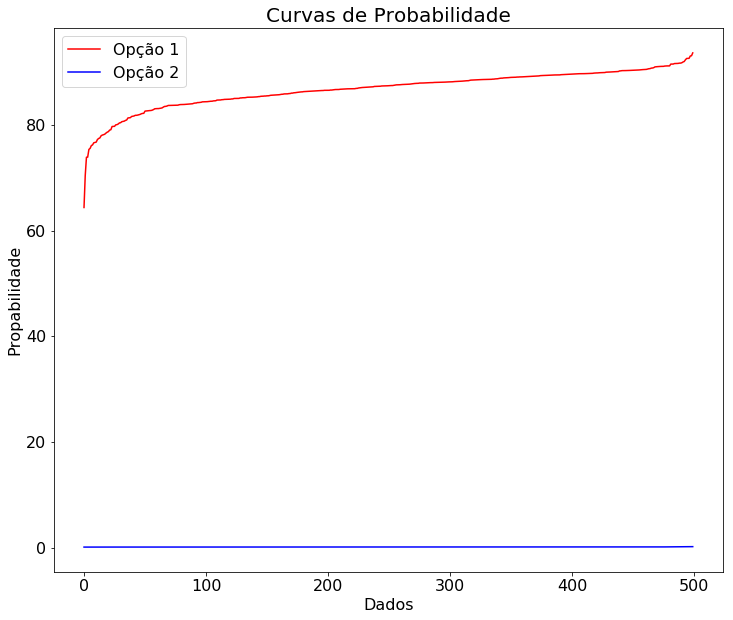

In [350]:
plt.figure(figsize=(12,10))
plt.rc('axes', titlesize=20)
plt.rc('font', size=16)
plt.plot(range(0,len(df_atmes[:500])),np.sort(ests1[:500])*100,color='r',label=u"Opção 1")
plt.plot(range(0,len(df_atmes[:500])),np.sort(ests2[:500])*100,color='b',label=u"Opção 2")
plt.xlabel('Dados')
plt.ylabel('Propabilidade')
plt.title('Curvas de Probabilidade')
plt.legend()
plt.show()

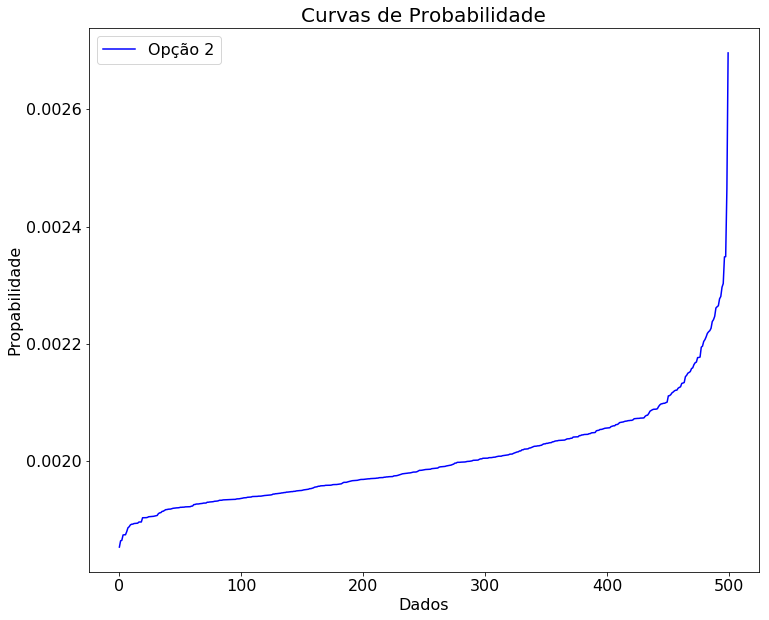

In [351]:
plt.figure(figsize=(12,10))
plt.rc('axes', titlesize=20)
plt.rc('font', size=16)
plt.plot(range(0,len(df_atmes[:500])),np.sort(ests2[:500]),color='b',label=u"Opção 2")
plt.xlabel('Dados')
plt.ylabel('Propabilidade')
plt.title('Curvas de Probabilidade')
plt.legend()
plt.show()

# Variational Autoencoder